# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train_original, y_train_original = train['features'], train['labels']
X_test_original, y_test_original = test['features'], test['labels']

In [2]:
# load category text labels
import csv
signnames = []
with open('signnames.csv', 'r') as file:
    namereader = csv.reader(file, delimiter=',')
    next(namereader, None)
    for row in namereader:
        signnames.append(row[1])

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [3]:
### Replace each question mark with the appropriate value.

# Number of training examples
n_train = len(X_train_original)

# Number of testing examples.
n_test = len(X_test_original)

# What's the shape of an traffic sign image?
image_shape = X_train_original[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train_original))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

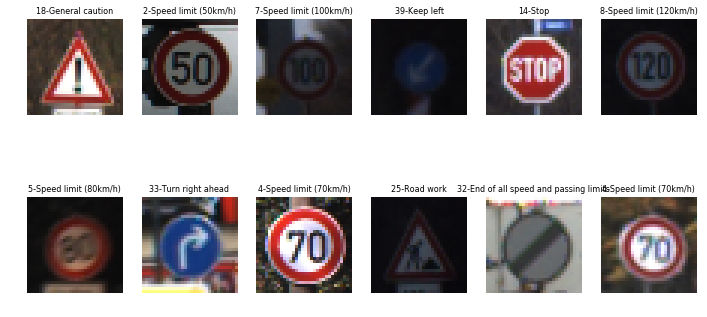

In [4]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import numpy as np
# Visualizations will be shown in the notebook.
%matplotlib inline

#Function to plot signs in a grid with their corresponding class id and name
def plot_signs(images, labels, rows=2, cols=6):

    numImages = min(len(images),rows*cols)
    selection = np.random.choice(images.shape[0], numImages, replace=False)       
    selectedImages = images[selection]
    
    f, axarr = plt.subplots(rows, cols, figsize=(12, 3*rows))
    for row in range(rows):
        for col in range(cols):
            index = (row*cols)+col
            if index >= len(selectedImages):
                break
                
            ax = axarr[row,col] if rows > 1 else axarr[col]
            ax.imshow(selectedImages[index])
            ax.axis('off')

            label_id = labels[selection][index]
            ax.set_title('%s-%s' % (label_id, signnames[label_id]), fontsize=8)
                
plot_signs(X_train_original, y_train_original,2,6)

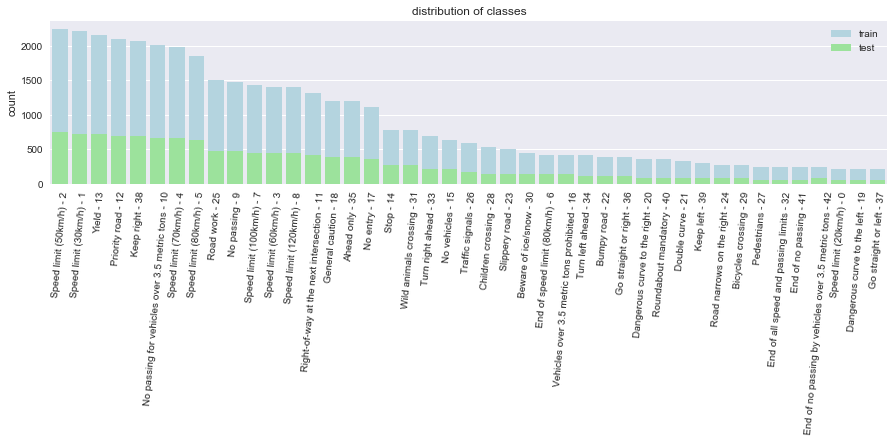

In [5]:
import seaborn as sns
from collections import Counter

train_counter = Counter(y_train_original)
order = list(zip(*train_counter.most_common()))[0]

f, ax = plt.subplots(figsize=(15, 3))
ax = sns.countplot(x=y_train_original, order=order, color='lightblue', ax=ax, label="train")
ax = sns.countplot(x=y_test_original, order=order, color='lightgreen', ax=ax, label="test")

_ = ax.set_title('distribution of classes')
_ = ax.legend()
_ = ax.set_xticklabels(['%s - %s'% (signnames[i], i) for i in order], rotation=85)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [57]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

In [10]:
import cv2
from sklearn.utils import shuffle

def normalize(X):
    X = (X / 255.0) - .5
    return X

def equalize(X):
    for c in range(0,3):
        channel = X[:,:,c]
        channel = channel.astype(np.uint8)
        channel = cv2.equalizeHist(channel)
        X[:,:,c] = channel    
    return X
        
def preprocess(X):
    result = []
    for i in range(0,X.shape[0]):
        x = np.array(X[i,:,:,:])
        equalize(x)
        x = normalize(x)
        result.append(x)
    
    return np.array(result)

# Visualization only:
# Training examples are preprocessed online during training/augmentation.
X_train = preprocess(X_train_original)
y_train = y_train_original

X_test = preprocess(X_test_original)
y_test = y_test_original

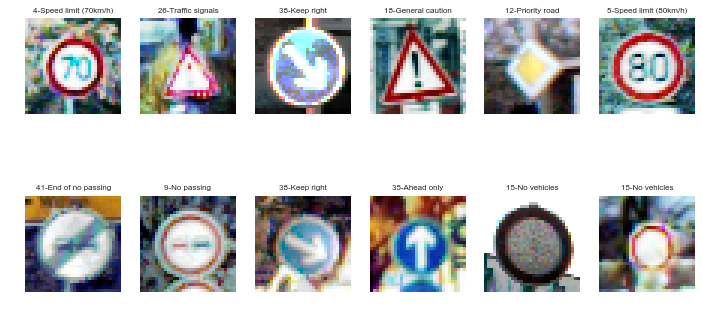

In [11]:
plot_signs(X_train+.5, y_train,2,6)

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

# Todo

**Answer:**

My preprocessing comprises two steps:
- First, I use histogram normalization on the individual color channels to improve contrast and accentuate edges.
- Then I normalize all data between -.5 and .5 to prevent saturation of neurons in the ConvNet.

In [16]:
### Generate additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

(12630, 32, 32, 3)
(12, 32, 32, 3)


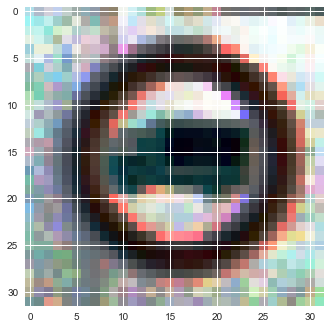

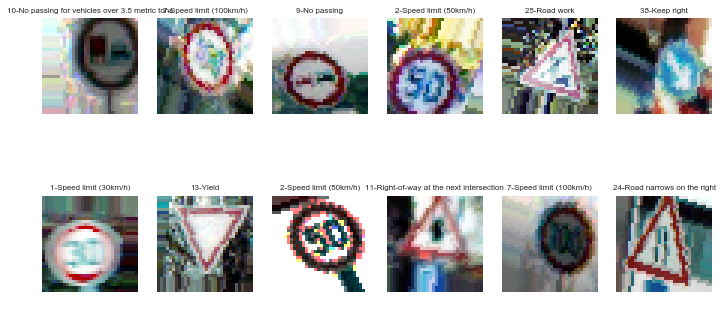

In [17]:
# This block experiments with the keras ImageDataGenerator
# It is not actually used for preprocessing at the moment

from keras.preprocessing.image import ImageDataGenerator
import numpy as np

datagen = ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=.1,
    zoom_range=0.2,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None)

# print('fitting')
# datagen.fit(X_test[0:20])
# print('fitting done')


for X_batch, y_batch in datagen.flow(X_test[0:200], y_test[0:200], batch_size=12):
    print(X_test.shape)
    print(X_batch.shape)
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    ax1.imshow(X_test[0]+.5)
    plot_signs(X_batch+.5,y_batch,2,6)
    break;
      
# print(X_batch[0,:,:,:])

In [18]:
from sklearn.model_selection import train_test_split
test_fraction = .2
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=test_fraction)

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

- The training data is split at random into a training set and a validation set. 80% are used for training, 20% for validation.


- I also experimented with the keras image generator to introduce some jitter into the training data (e.g. rotations, shifts, shear and zoom) but I have not yet had the time to train the net with these images.

In [64]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

In [19]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x16.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 16), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(16))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x16. Output = 14x14x16.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 32.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 32), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(32))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x32. Output = 5x5x32.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x32. Output = 800.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 800. Output = 240.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(800, 240), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(240))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 240. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(240, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [20]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

The final model has ...

**TODO**

In [67]:
### Train your model here.
### Feel free to use as many code cells as needed.

In [21]:
rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [22]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver(keep_checkpoint_every_n_hours=1)

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [23]:
# This cell trains a new model and saves it under save_path
save_path = './lenet-original'

EPOCHS = 15
BATCH_SIZE = 128

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, save_path)
    print("Model saved as {}".format(save_path))

Training...

EPOCH 1 ...
Validation Accuracy = 0.922

EPOCH 2 ...
Validation Accuracy = 0.959

EPOCH 3 ...
Validation Accuracy = 0.960

EPOCH 4 ...
Validation Accuracy = 0.972

EPOCH 5 ...
Validation Accuracy = 0.970

EPOCH 6 ...
Validation Accuracy = 0.978

EPOCH 7 ...
Validation Accuracy = 0.986

EPOCH 8 ...
Validation Accuracy = 0.988

EPOCH 9 ...
Validation Accuracy = 0.976

EPOCH 10 ...
Validation Accuracy = 0.983

EPOCH 11 ...
Validation Accuracy = 0.985

EPOCH 12 ...
Validation Accuracy = 0.985

EPOCH 13 ...
Validation Accuracy = 0.986

EPOCH 14 ...
Validation Accuracy = 0.982

EPOCH 15 ...
Validation Accuracy = 0.980

Model saved as ./lenet-original


In [71]:
#Select model to run the rest of the notebook with
save_path = './lenet-original'

In [ ]:
# this cell can be used to cotinue training of an already saved model

EPOCHS = 2
BATCH_SIZE = 256

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    print("Restoring from {}".format(save_path))
    saver.restore(sess, save_path)
    print("{} restored".format(save_path))
    
    num_examples = len(X_train)
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, save_path)
    print("Model saved")

In [ ]:
# Evaluate using current model
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.4f}".format(test_accuracy))

In [24]:
#Evaluate from saved model
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    print("Restoring from {}".format(save_path))
    saver.restore(sess, save_path)
    test_accuracy = evaluate(X_test, y_test)
    print("Test Acc. = {:.4f}".format(test_accuracy))

Restoring from ./lenet-original
Test Acc. = 0.9225


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

I used the Adam optimizer to train the network. Adam is an adaptive stochastic gradient descent optimizer which uses two momentum coefficients in order to predict the direction of the gradient.
As batch size I used 128 since the computer I trained on had just about enough memory to handle this batch size.
I trained the model for 15 Epochs. Validation accuray reached about 98% already after 5 Epochs and then remained at just over this value. I did not increase the model complexity to a point that would require more training.



### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

I started with the 'plug and play' variant of the LeNet architecture from the LeNet lab and achieved a reasonable validation accuracy of about 94%. I then increased the depth of the first two convolution layers (the first from 6 to 16 and the second from 16 to 32) as well as the size of the fully connected layers. This increased validation accuracy to up to 98%.
This model achieved an accuracy of about 92 % on the test data set.
I intend to set up AWS in the near future to be able to further increase the model complexity and train using the augmented / generated data. I believe that particularly the data augmentation would help the model to generalize better than training just on the preprocessed training data.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [25]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

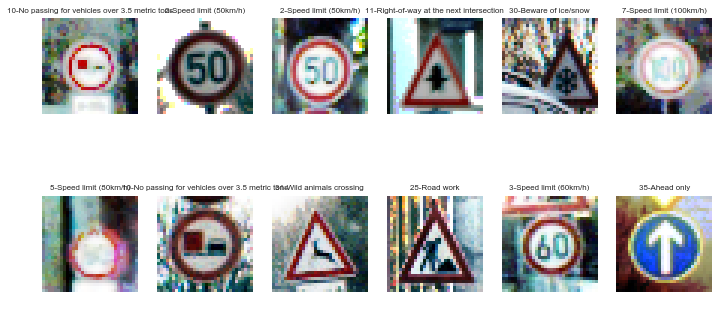

In [29]:
numImages = min(len(X_test),80)
selection = np.random.choice(X_test.shape[0], numImages, replace=False) 

X_new = X_test[selection]
y_new = y_test[selection]

plot_signs(X_new+.5, y_new,2,6)

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

**TODO**

In [30]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

In [31]:
softmax_op = tf.nn.softmax(logits)
top_k_op = tf.nn.top_k(softmax_op, k=5)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    saver.restore(sess, save_path)
    
    new_accuracy = evaluate(X_new, y_new)
    feed_dict = {x: X_new, y: y_new}
    ((top_values, top_indices), probabilities) = sess.run([top_k_op,softmax_op], feed_dict=feed_dict)
    
    print("Total Accuracy on the extra set: {:.4f}".format(new_accuracy))

    predicted_classes = probabilities.argmax(axis=1)
    false_classified_indices = np.where(predicted_classes != y_new)


Total Accuracy on the extra set: 0.8500


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

**TODO**

In [32]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

In [35]:
def plot_probabilities(images, top_indices, top_values, num_cols=2):
    numImages = min(len(images),5)
    selection = np.random.choice(images.shape[0], numImages, replace=False) 

    images_selection = images[selection]
    top_indices_selection = top_indices[selection]
    top_values_selection = top_values[selection]
    
    for i in range(numImages):
        n = int(images_selection.shape[0])
        num_rows = n
        row = i
        ax1 = plt.subplot2grid((num_rows,num_cols),(row, 0))
        ax2 = plt.subplot2grid((num_rows,num_cols),(row, 1))
        img = images_selection[i,:,:,:]
        ax1.axis('off')
        ax1.imshow(img+.5)
        ind = np.arange(5)
        ax2.barh(ind[::-1],top_values_selection[i,:])
        ax2.set_autoscalex_on(False)
        ax2.set_xlim([0,1.000])
        ax2.set_yticks(ind + 0.5)
        ax2.set_yticklabels(map(lambda x: str(x), reversed(top_indices_selection[i,:])))

        for j in range(5):
            index = top_indices_selection[i,4-j]
            ax2.text(1.1, j + 0.4, signnames[index])

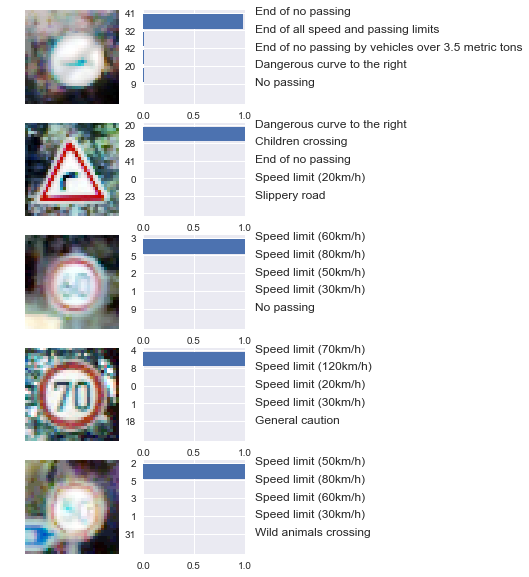

In [36]:
num_rows = 5
plt.figure(figsize=(4,2 * num_rows))

plot_probabilities(X_new, top_indices, top_values)

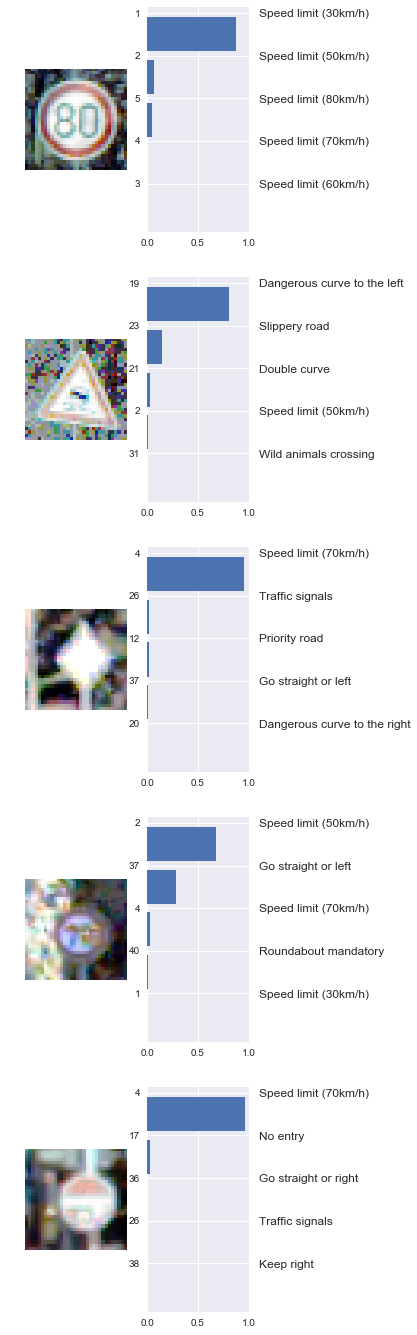

In [38]:
n = len(false_classified_indices[0])
num_cols = 2
num_rows = n
plt.figure(figsize=(4,2 * num_rows))

for i in range(len(false_classified_indices[0])):
    plot_probabilities(X_new[false_classified_indices], top_indices[false_classified_indices], top_values[false_classified_indices])

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.